In [1]:
# ref. https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

In [2]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms 
import torchvision.models as models

import copy

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cpu')

In [5]:
!ls

images	Neural_Style_with_PyTorch.ipynb


In [6]:
!ls images/

dancing.jpg  picasso.jpg


In [7]:
imsize = 512 if torch.cuda.is_available() else 128

In [8]:
imsize

128

In [9]:
# you will scale the image to imsize and then will transform it to tensor
loader = transforms.Compose([ transforms.Resize(imsize), transforms.ToTensor()])

In [10]:
# defining the image_loader function : load and transform image using device(cpu)
def images_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [11]:
style_img = images_loader('images/picasso.jpg')
content_img = images_loader('images/dancing.jpg')

In [12]:
# is necessary to have the same size for content and style image
assert style_img.size() == content_img.size()

In [13]:
# TIPs
#  torch library are trained with 0-1 tensor image.
#  Caffe library: they are trained with 0-255 tensor images.

In [14]:
# to see images
unloader = transforms.ToPILImage()
plt.ion()

In [15]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

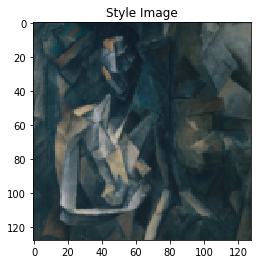

In [16]:
plt.figure()
imshow(style_img, title='Style Image')

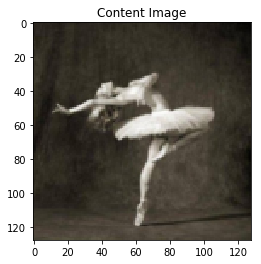

In [17]:
plt.figure()
imshow(content_img, title='Content Image')

#### defininf the content loss

In [18]:
class ContentLoss(nn.Module):
    
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

#### defining the style loss

In [19]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div( a * b * c * d)

class StyleLoss(nn.Module):
    
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

#### loading a pre-trained network

In [20]:
'''
 PyTorch’s implementation of VGG is a module divided in two child Sequential modules: 
 FEATURES (containing convolution and pooling layers) and 
 CLASSIFIER (containing fully connected layers).
'''

'\n PyTorch’s implementation of VGG is a module divided in two child Sequential modules: \n FEATURES (containing convolution and pooling layers) and \n CLASSIFIER (containing fully connected layers).\n'

In [21]:
cnn = models.vgg19(pretrained=True).features.to(device).eval() # using as feature extractor

In [22]:
# we will normalize the channels (mean,std)
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [23]:
# create a module to normalize input image so  we can easily put in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
        
    def forward(self, img):
        return (img - self.mean) / self.std

In [24]:
# For instance, vgg19.features contains a sequence 
# (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…)
# we wand to add our style and content loss modules 
# as additive ‘transparent’ layers in our network, at desired depths 

In [25]:
# desired depth layers to compute style and content losses 
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [26]:
def get_style_model_and_losses(cnn, normalization_mean, normalizacion_std, 
                              style_img, content_img,
                              content_layers=content_layers_default,
                              style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    
    normalization = Normalization(normalization_mean, normalizacion_std).to(device)
    
    content_losses = []
    style_losses = []
    
    model = nn.Sequential(normalization)
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            
        model.add_module(name, layer)
        
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module('content_loss_{}'.format(i), content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module('style_loss_{}'.format(i), style_loss)
            style_losses.append(style_loss)
            
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
            
    model = model[:(i + 1)]
    
    return model, style_losses, content_losses

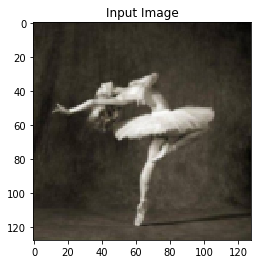

In [27]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

#### gradient descent

In [28]:
# Unlike training a network, we want to train the input image in order 
# to minimise the content/style losses.

In [29]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [30]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                      content_img, style_img, input_img, num_steps=100,
                      style_weight=1000000, content_weight=1):
    print('building the style transfer model...')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                     normalization_mean, 
                                                                     normalization_std,
                                                                     style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    print('Optimizing...')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
                
            style_score *= style_weight
            content_score *= content_weight 
            
            loss = style_score + content_score
            loss.backward()
            
            run[0] += 1
            if run[0] % 50 == 0:
                print('run {}:'.format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
                
            return style_score + content_score
        
        optimizer.step(closure)
        
    input_img.data.clamp_(0, 1)
    
    return input_img

#### running the algorithm

building the style transfer model...
Optimizing...
run [50]:
Style Loss : 120.478058 Content Loss: 18.786619

run [100]:
Style Loss : 32.861347 Content Loss: 17.117075



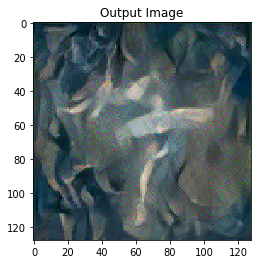

In [31]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                           content_img, style_img, input_img)
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()